# **TRAINING A SIMPLE CONVOLUTIONAL NEURAL NETWORK**

"MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike."

[Read more.](https://www.kaggle.com/c/digit-recognizer)


<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>

The most crucial task as a Data Scientist is to gather the perfect dataset and to understand it thoroughly. Trust me, the rest is a lot easier. For this project, we will be using the popular [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) database. It is a collection of 70000 handwritten digits split into training and test set of 60000 and 10000 images respectively.

The data set is originally available on [Yann Lecun’s website](http://yann.lecun.com/exdb/mnist/). Cleaning the data is one of the biggest tasks. Don’t forget — **“Garbage in, garbage out !”**. Luckily, for us PyTorch provides an easy implementation to download the cleaned and already prepared data, using a few lines of code. Before starting, we need to make all the necessary installation and imports of the relevant packages.

In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)

1.11.0+cu113


## Import The Data
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning. 

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models. 
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. I encourage you to experiment with different batches.

In [ ]:
%%capture
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

## Exploring the Data
As a practioner and researcher, one should always spend a bit of time and effort exploring and understanding the dataset. It's fun and this is a good practise to ensure that everything is in order. 

Let's check what the train and test dataset contains. I will use `matplotlib` to print out some of the images from our dataset. 

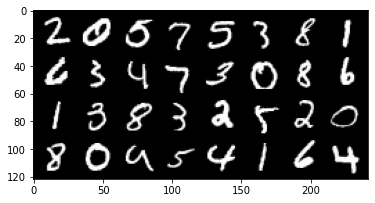

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

Let's check the dimensions of a batch.

In [ ]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


## The Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model. 

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `nn.Conv2d(...)`. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`. We hope to get a nice representation of this layer, so we use `out_channels=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d). 
- We use 2 back to back dense layers or what we refer to as linear transformations to the incoming data. Notice for `d1` I have a dimension which looks like it came out of nowhere. 128 represents the size we want as output and the (`26*26*32`) represents the dimension of the incoming data. If you would like to find out how to calculate those numbers refer to the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d). In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer. The same applies for the second linear transformation (`d2`) where the dimension of the output of the previous linear layer was added as `in_features=128`, and `10` is just the size of the output which also corresponds to the number of classes.
- After each one of those layers, we also apply an activation function such as `ReLU`. For prediction purposes, we then apply a `softmax` layer to the last transformation and return the output of that.  

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [ ]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [ ]:
out

## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. 

In [ ]:
learning_rate = 0.001
num_epochs = 15

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

Now it's time for training.

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))        

Epoch: 0 | Loss: 1.7645 | Train Accuracy: 69.74
Epoch: 1 | Loss: 1.5425 | Train Accuracy: 92.16
Epoch: 2 | Loss: 1.4857 | Train Accuracy: 97.83
Epoch: 3 | Loss: 1.4789 | Train Accuracy: 98.48
Epoch: 4 | Loss: 1.4755 | Train Accuracy: 98.77


We can also compute accuracy on the testing dataset to see how well the model performs on the image classificaiton task. As you can see below, our basic CNN model is performing very well on the MNIST classification task.

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.13


## Final Words
Congratulations! You are now able to implement a basic CNN model in PyTorch for image classification. If you would like, you can further extend the CNN model by adding more convolution layers and max pooling. 

**Challenge Problem** : List out some of the hyperparameters used in the CNN trained above